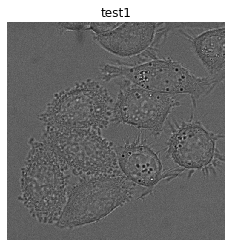

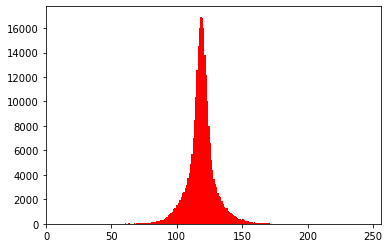

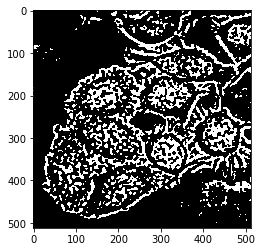

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import watershed
from sklearn.cluster import MeanShift
from skimage.feature import peak_local_max


img = cv2.imread('./data/DIC-C2DH-HeLa/Sequence 1/t002.tif',cv2.IMREAD_UNCHANGED)

plt.figure('test1')
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('test1')
plt.show()

hist,bins = np.histogram(img.flatten(),256,[0,256])
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

kernel = 11
img  =cv2.GaussianBlur(img,(kernel,kernel),0)
hist,bins = np.histogram(img.flatten(),256,[0,256])
th  = np.where(hist ==np.max(hist) )

ret, thresh = cv2.threshold(img,th[0]+1,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap='gray')
plt.show()

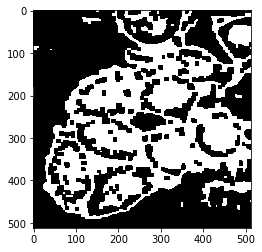

In [23]:
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,np.ones((9,9)))
opening = cv2.morphologyEx(closing,cv2.MORPH_OPEN,np.ones((4,4)))
plt.imshow(opening,cmap='gray')
plt.show()

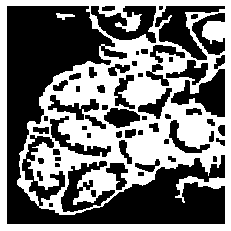

In [24]:
connectivity = 8 # or whatever you prefer
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(opening, connectivity,cv2.CV_32S)
sizes = stats[1:, -1]
nb_components = nb_components - 1
# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 250
#your answer image
img2 = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img2[output == i + 1] = 255

plt.figure()
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.show()

c:\users\user\documents\study\lib\site-packages\ipykernel_launcher.py:57: UserWarning: The following kwargs were not used by contour: 'linewidth'


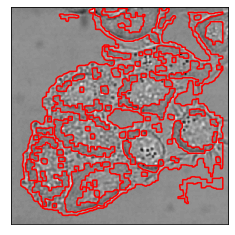

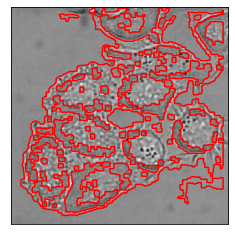

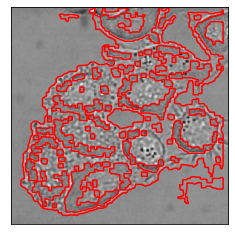

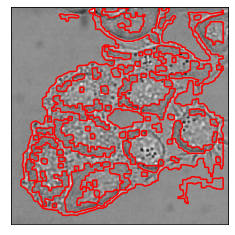

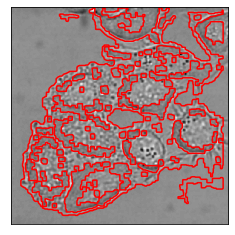

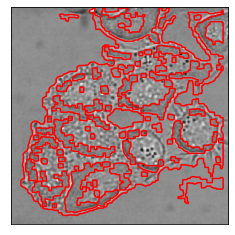

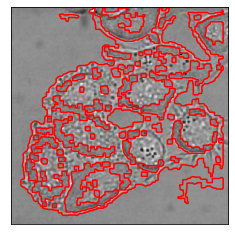

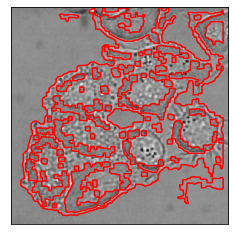

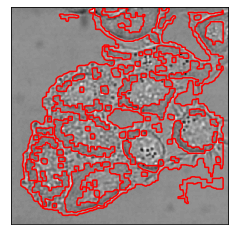

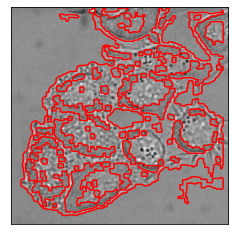

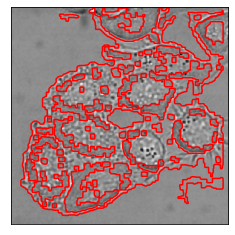

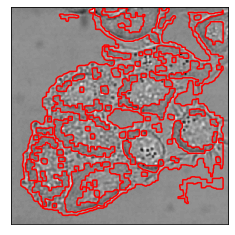

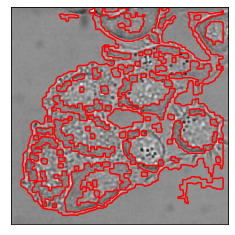

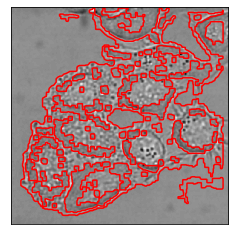

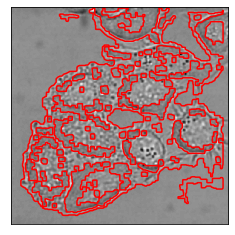

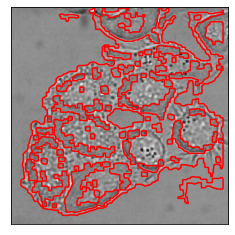

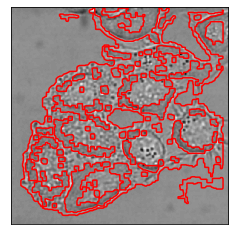

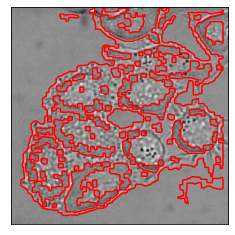

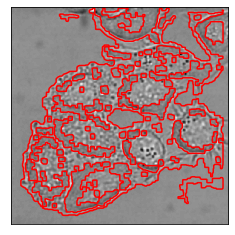

In [27]:
from pylab import *

IniLSF = np.ones((img.shape[0], img.shape[1]), img.dtype)
IniLSF[3:500, 3:500] = -1
IniLSF = -IniLSF
 
def mat_math(intput, str):
    output = intput
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if str == "atan":
                output[i, j] = math.atan(intput[i, j])
            if str == "sqrt":
                output[i, j] = math.sqrt(intput[i, j])
    return output
 
 
# CV函数
def CV(LSF, img, mu, nu, epison, step):
 
    Drc = (epison / math.pi) / (epison*epison + LSF*LSF)
    Hea = 0.5*(1 + (2 / math.pi)*mat_math(LSF/epison, "atan"))
    Iy, Ix = np.gradient(LSF)
    s = mat_math(Ix*Ix+Iy*Iy, "sqrt")
    Nx = Ix / (s+0.000001)
    Ny = Iy / (s+0.000001)
    Mxx, Nxx = np.gradient(Nx)
    Nyy, Myy = np.gradient(Ny)
    cur = Nxx + Nyy
    Length = nu*Drc*cur
 
    Lap = cv2.Laplacian(LSF, -1)
    Penalty = mu*(Lap - cur)
 
    s1 = Hea*img
    s2 = (1-Hea)*img
    s3 = 1-Hea
    C1 = s1.sum() / Hea.sum()
    C2 = s2.sum() / s3.sum()
    CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2))
 
    LSF = LSF + step*(Length + Penalty + CVterm)
    # plt.imshow(s, cmap ='gray'),plt.show()
    return LSF
 
# 模型参数
mu = 1
nu = 0.003 * 255 * 255
num = 20
epison = 1
step = 0.1
LSF = IniLSF
for i in range(1, num):
    LSF = CV(LSF, img2, mu, nu, epison, step)  # 迭代
    if i % 1 == 0:  # 显示分割轮廓
        plt.imshow(img,cmap='gray'), plt.xticks([]), plt.yticks([])
        plt.contour(LSF, [0], colors='r', linewidth=2)
        plt.draw(), plt.show(block=False), plt.pause(0.01)
